## Data Preparation

In [1]:
import numpy as np
from tqdm import tqdm
import json
from collections import Counter
from collections import defaultdict
from scipy import sparse
from sklearn.feature_extraction.text import CountVectorizer
# lemmatisation
from nltk.stem import WordNetLemmatizer

In [2]:
dataLines = []
with open("../../Data/preProcess.txt") as file:
    for line in tqdm(file):
        if line == " ":
            continue
        dataLines.append(line)

print("Number of lines: ", len(dataLines))

4607047it [00:06, 740999.06it/s] 

Number of lines:  4607047


In [3]:
lemma = WordNetLemmatizer()
def lemmatize(dataLines):
    newData = []
    for line in tqdm(dataLines):
        words = line.split()
        for i in range(len(words)):
            words[i] = lemma.lemmatize(words[i])
        newData.append(" ".join(words))
    return newData


def preProcessing(dataLines,minFreq):
    # lemmatize the data
    dataLines = lemmatize(dataLines)
    wordCount = defaultdict(int)

    for line in tqdm(dataLines):
        line = line.lower()
        for word in line.split():
            wordCount[word] += 1
    newData = []
    # replace with <unk> if frequency is less than minFreq
    for line in tqdm(dataLines):
        words = line.split()
        for i in range(len(words)):
            if wordCount[words[i]] < minFreq:
                words[i] = "<UNK>"
        newData.append(" ".join(words))


    # save the dataLines in review.txt
    with open("../../Data/preProcess.txt", "w") as file:
        for line in newData:
            file.write(line + "\n")

    return newData

datalines = preProcessing(dataLines,350)


100%|██████████| 4607047/4607047 [02:57<00:00, 25894.55it/s]


In [3]:
from nltk.tokenize import word_tokenize

class SVD:
    def __init__(self,window_size, cutoff, data):
        self.data = data
        self.window_size = window_size
        self.cutoff = cutoff
        self.wordDict = defaultdict(int)
        self.wordCount = 0
        self.minfreq = 200
        self.word2id = {}
        self.id2word = {}
        self.vocab = []
        self.vocabSize = 0
        self.cooccur = defaultdict(int)
        self.cooccurMatrix = None
        self.wordTokens = []
        self.U = None
        self.S = None
        self.V = None
        self.dim = 0
        self.createVocab()
        self.createCooccurMatrix()
        self.createSVD()
        self.saveEmbeddings()


    def createVocab(self):
        for sent in tqdm(self.data):
            sent = sent.split()
            words = [x for x in sent]
            self.wordTokens.append(words)
            for word in sent:
                self.wordDict[word] += 1
                self.wordCount += 1
            if self.wordCount%1000000 == 0:
                print("Number of words processed: ", self.wordCount)
        
        self.vocab = list(self.wordDict.keys())
        print("Vocab size: ", len(self.vocab))

        with open("wordTokens.txt","w") as f:
            for sent in self.wordTokens:
                f.write(" ".join(sent) + "\n")
        
        print("Tokens created")
        self.vocabSize = len(self.vocab)
        self.cooccurMatrix = sparse.lil_matrix((self.vocabSize,self.vocabSize))

        with open("vocab.txt","w") as f:
            for ind,word in enumerate(self.vocab):
                self.word2id[word] = ind
                self.id2word[ind] = word
                f.write(word + " " + str(ind) + "\n")
        print("Vocab created")

    def createCooccurMatrix(self):
        with open("wordTokens.txt" , "r") as f:
            for line in tqdm(f):
                line = line.split()
                first_window = line[:self.window_size]
                if self.window_size > len(line):
                    continue
                for t,word in enumerate(line[:-self.window_size]):
                    word_ind = self.word2id[word]
                    first_window = first_window[1:] + [line[t+self.window_size]]
                    for context_word in first_window:
                        context_ind = self.word2id[context_word]
                        try:
                            self.cooccurMatrix[word_ind,context_ind] += 1
                        except:
                            self.cooccurMatrix[word_ind,context_ind] = 1
                        try:
                            self.cooccurMatrix[context_ind,word_ind] += 1
                        except:
                            self.cooccurMatrix[context_ind,word_ind] = 1

        print("Cooccurrence matrix created")

    def createSVD(self):
        u,s,v = sparse.linalg.svds(self.cooccurMatrix,which='LM',k=100)
        print(u.shape,s.shape,v.shape)
        deno = sum(s)
        sum_count = 0
        # maximum variance cutoff
        for i,x in enumerate(s):
            sum_count += x
            if sum_count/deno > self.cutoff:
                self.dim = i+1
                break
        self.U = u[:,:self.dim]
        self.S = s[:self.dim]
        self.V = v[:self.dim,:]

        # normalise
        norms_u = np.linalg.norm(self.U, axis=1, keepdims=True)
        self.U = np.where(norms_u < 1e-8, self.U, self.U / (norms_u + 1e-8))

        norms_v = np.linalg.norm(self.V, axis=1, keepdims=True)
        self.V = np.where(norms_v < 1e-8, self.V, self.V / (norms_v + 1e-8))

        print("SVD done")

    def saveEmbeddings(self):
        with open("embeddings.txt","w") as f:
            for word,vec in zip(self.vocab,self.U):
                f.write(word + " " + " ".join([str(x) for x in vec]) + "\n")




In [4]:
svd_ = SVD(7, 0.9, dataLines[:100000])


100%|██████████| 100000/100000 [00:06<00:00, 15840.63it/s]


Vocab size:  25089
Tokens created
Vocab created


100000it [13:03, 127.66it/s]


Cooccurrence matrix created
(25089, 100) (100,) (100, 25089)
SVD done


In [2]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import distance



# load the SVD matrix
svd_matrix = []
feature_list = []
with open("embeddings.txt") as file:
    for line in file:
        svd_matrix.append([float(x) for x in line.strip('\n').split(" ")[1:]])
        feature_list.append(line.strip('\n').split(" ")[0])

svd_matrix = np.array(svd_matrix)





In [52]:
def colorBars(words, token_list,svd_matrix, fileName):
    fig, axs = plt.subplots(nrows=len(words), ncols=1,
                            figsize=(20, 2*len(words)))
    color = ['brown','red', 'orange', 'yellow',
             'white', 'cyan', 'blue', 'purple','black']
    for i, word in enumerate(words):
        word_ind = token_list.index(word)
        vec = svd_matrix[word_ind]
        vec = vec/np.linalg.norm(vec)
        axs[i].bar(range(100), vec, color=color)
        axs[i].set_title(word)

    plt.tight_layout()
    plt.savefig(fileName)
    plt.show()

def plot_top_10_words(word,token_list,svd_matrix):
    def tsne_plot(results):
        words = [x[0] for x in results]
        tokens = [x[1] for x in results]
        words = np.array(words)
        tokens = np.array(tokens)

        tsne_model = TSNE(init='pca',perplexity=9,random_state=42)
        res_embeds = tsne_model.fit_transform(tokens)

        x_axis = res_embeds[:,0]
        y_axis = res_embeds[:,1]

        plt.figure(figsize=(10,10))
        for i in range(len(x_axis)):
            plt.scatter(x_axis[i],y_axis[i])
            plt.annotate(words[i],xy=(x_axis[i],y_axis[i]),xytext=(5,2),textcoords='offset points',ha='right',va='bottom')
        plt.savefig('./Results/' + word+'.png')
    
    if word not in token_list:
        print("Word not in vocab")
        word = '<UNK>'
    word_index = token_list.index(word)
    word_vector = svd_matrix[word_index]
    res = {}
    for i,embed in tqdm(enumerate(svd_matrix)):
        if i!=word_index:
            magnitude_product = np.linalg.norm(
               embed) * np.linalg.norm(word_vector)
            if magnitude_product == 0:
                res[i] = [np.nan, embed]
            else:
                cosine_distance = 1-distance.cosine(embed, word_vector)
            res[i] = [cosine_distance, embed]

    results = sorted(res.items(), key=lambda x: x[1][0], reverse=True)[:10]
    results = [(token_list[x[0]],x[1][1]) for x in results]

    print('Word: ', word)
    # print(results)
    print('Top 10 similar words: ', [x[0] for x in results])
    print_words = []
    print_words.append(word)
    for i in range(10):
        print_words.append(results[i][0])
    file_name = './Results/ '+word + "_bar.png"
    colorBars(print_words, token_list,svd_matrix, file_name)
    tsne_plot(results)


25089it [00:00, 25300.24it/s]


Word:  britain
Top 10 similar words:  ['germany', '1945', 'russia', 'japan', 'depression', '1943', 'widespread', 'italy', 'asia', '1918']


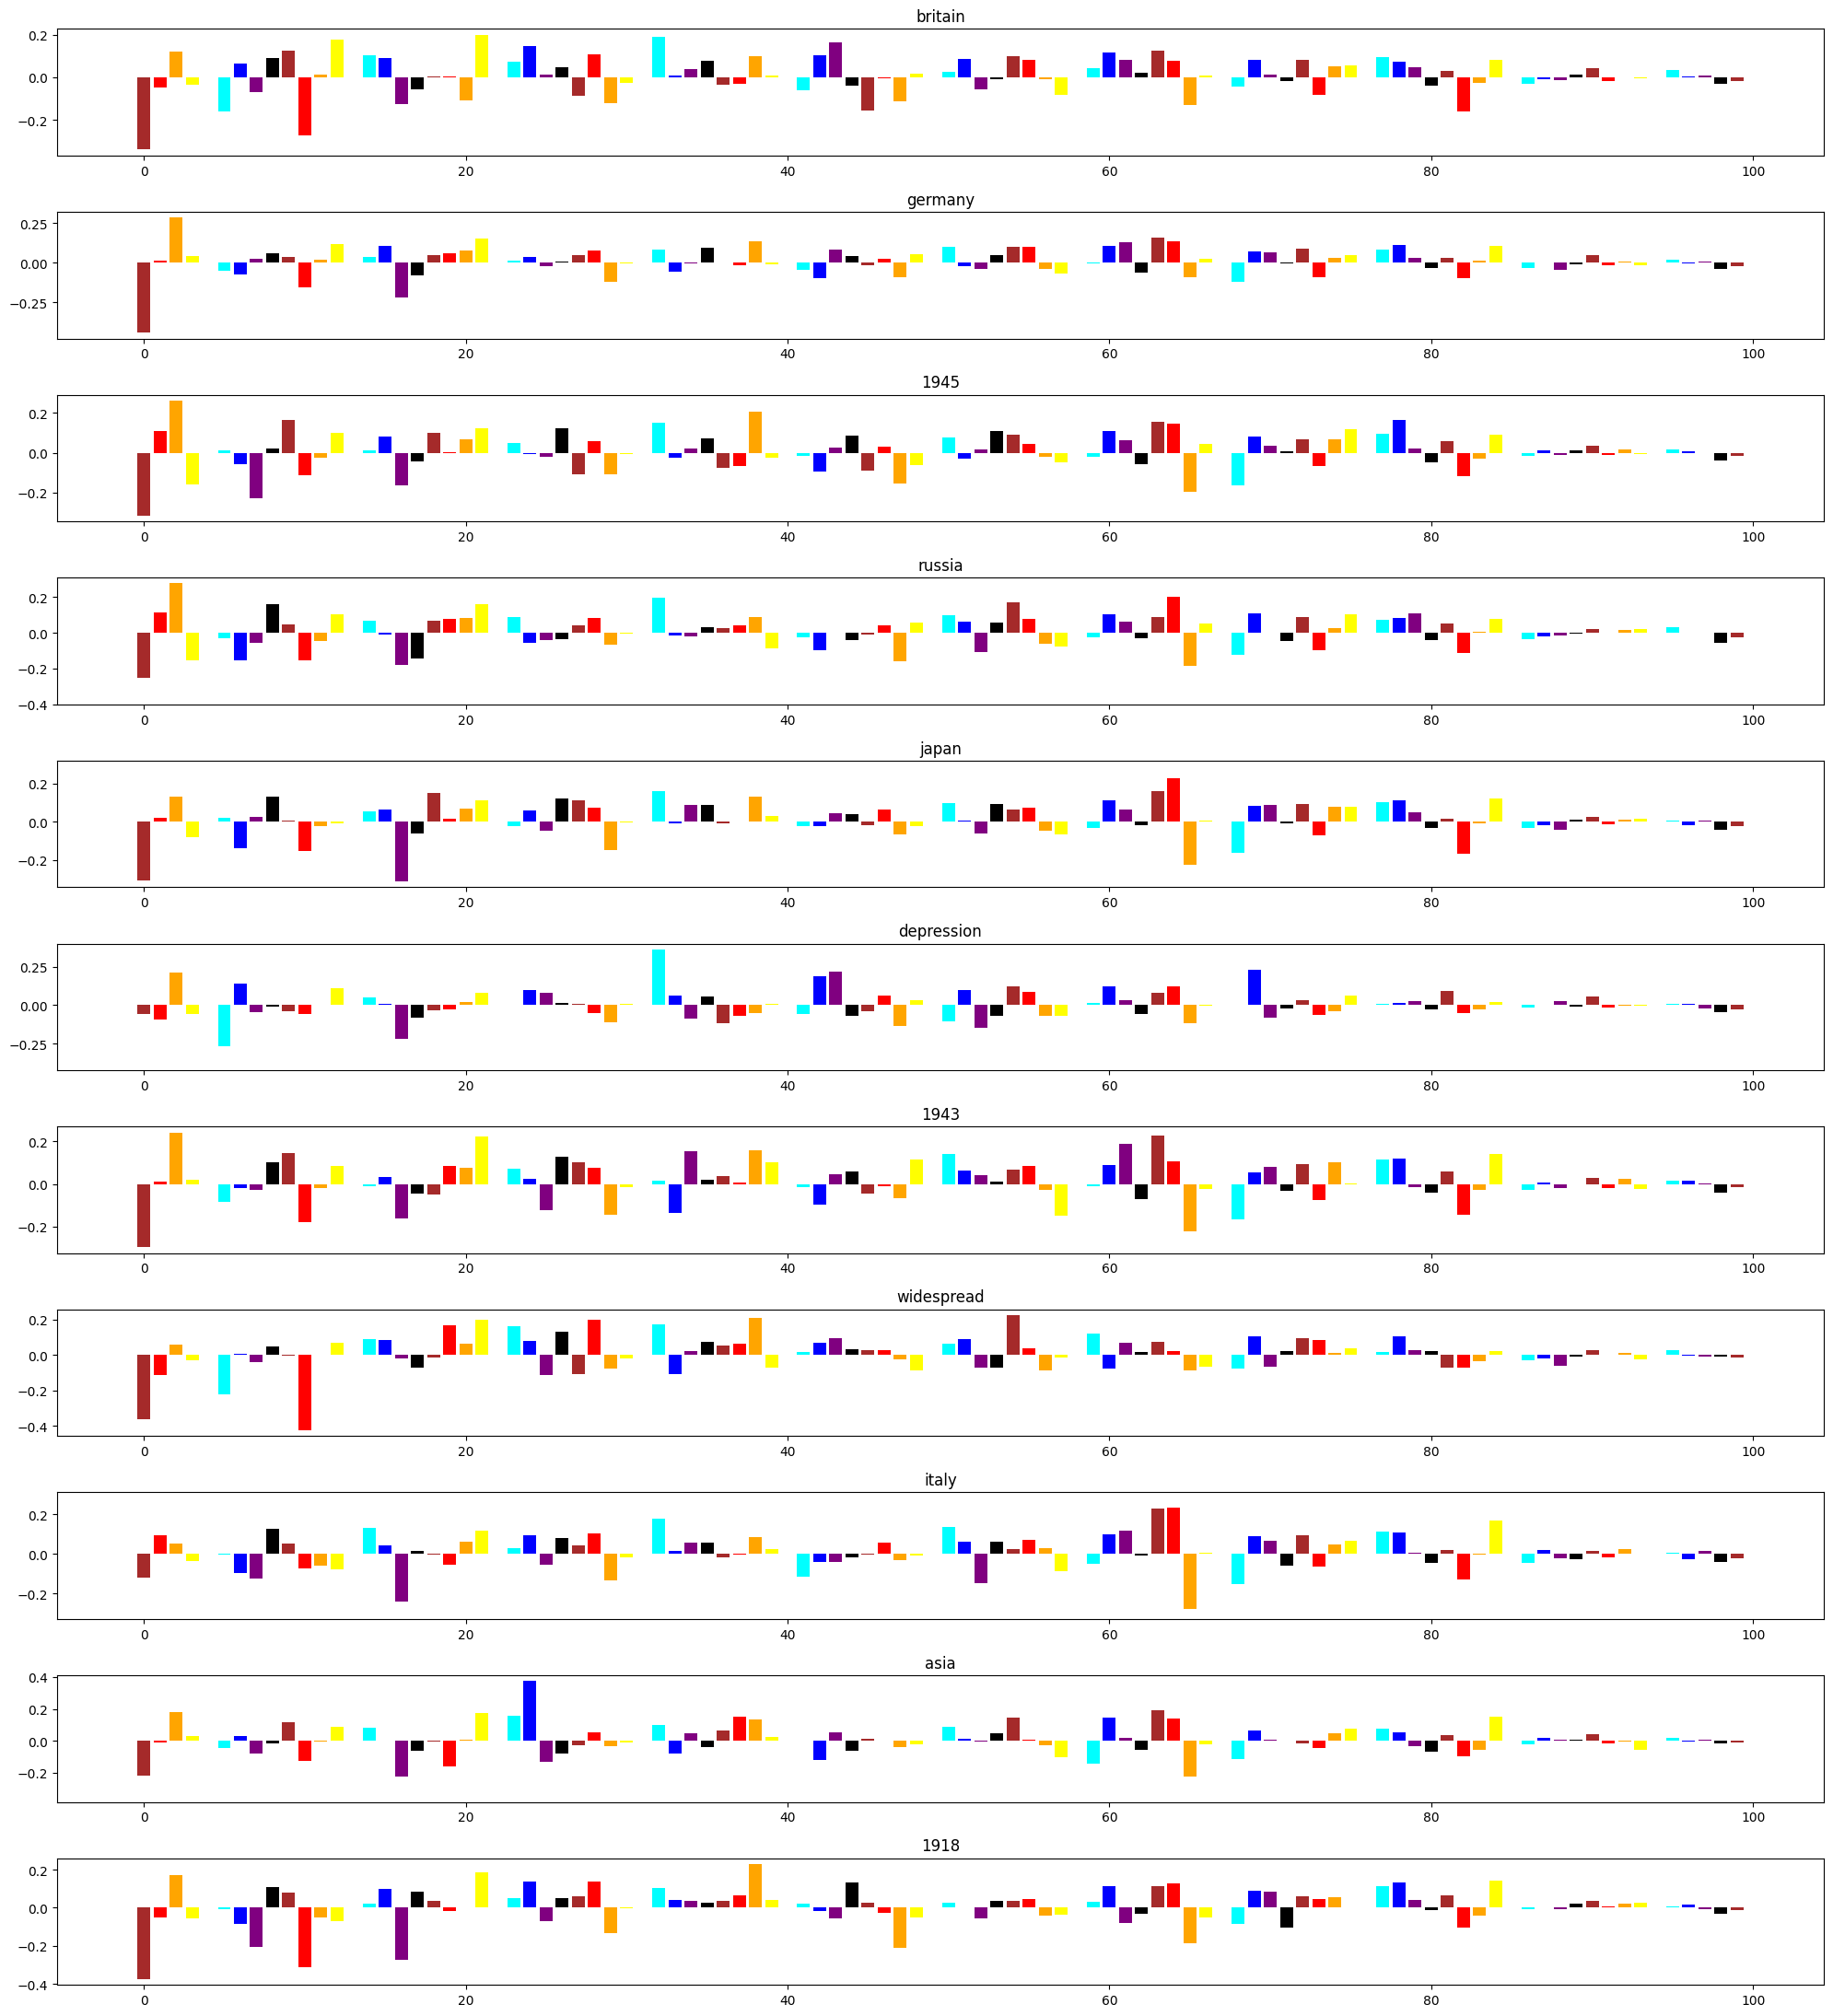

25089it [00:00, 25979.57it/s]


Word:  his
Top 10 similar words:  ['threatening', 'imitates', 'affirming', 'aquatic', 'brian', 'goose', 'stepford', 'uranus', 'himself', 'breathes']


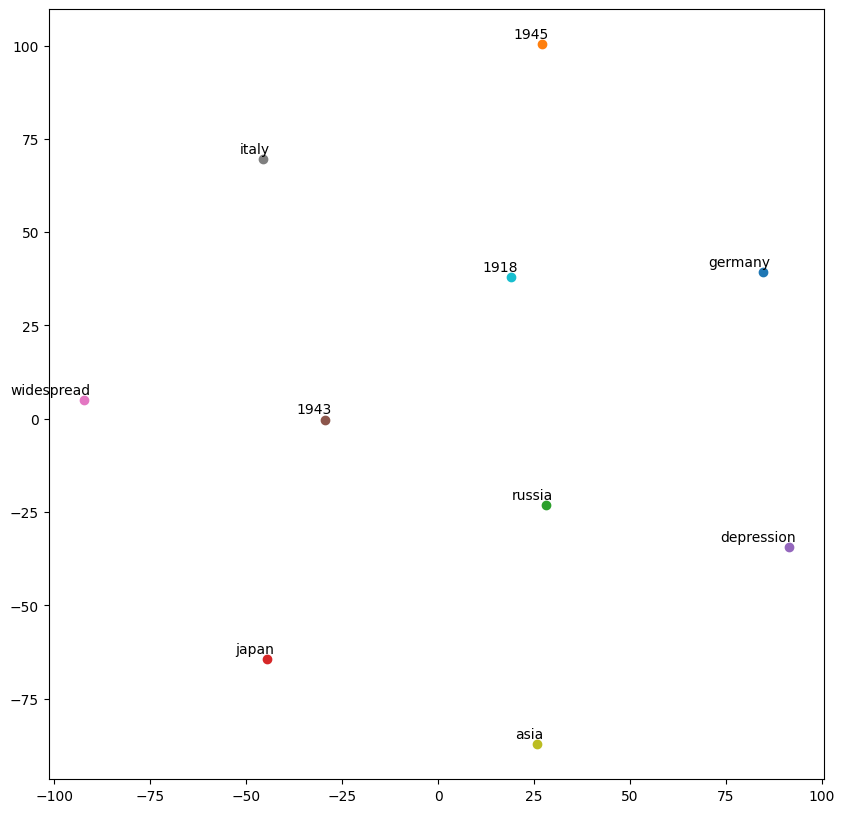

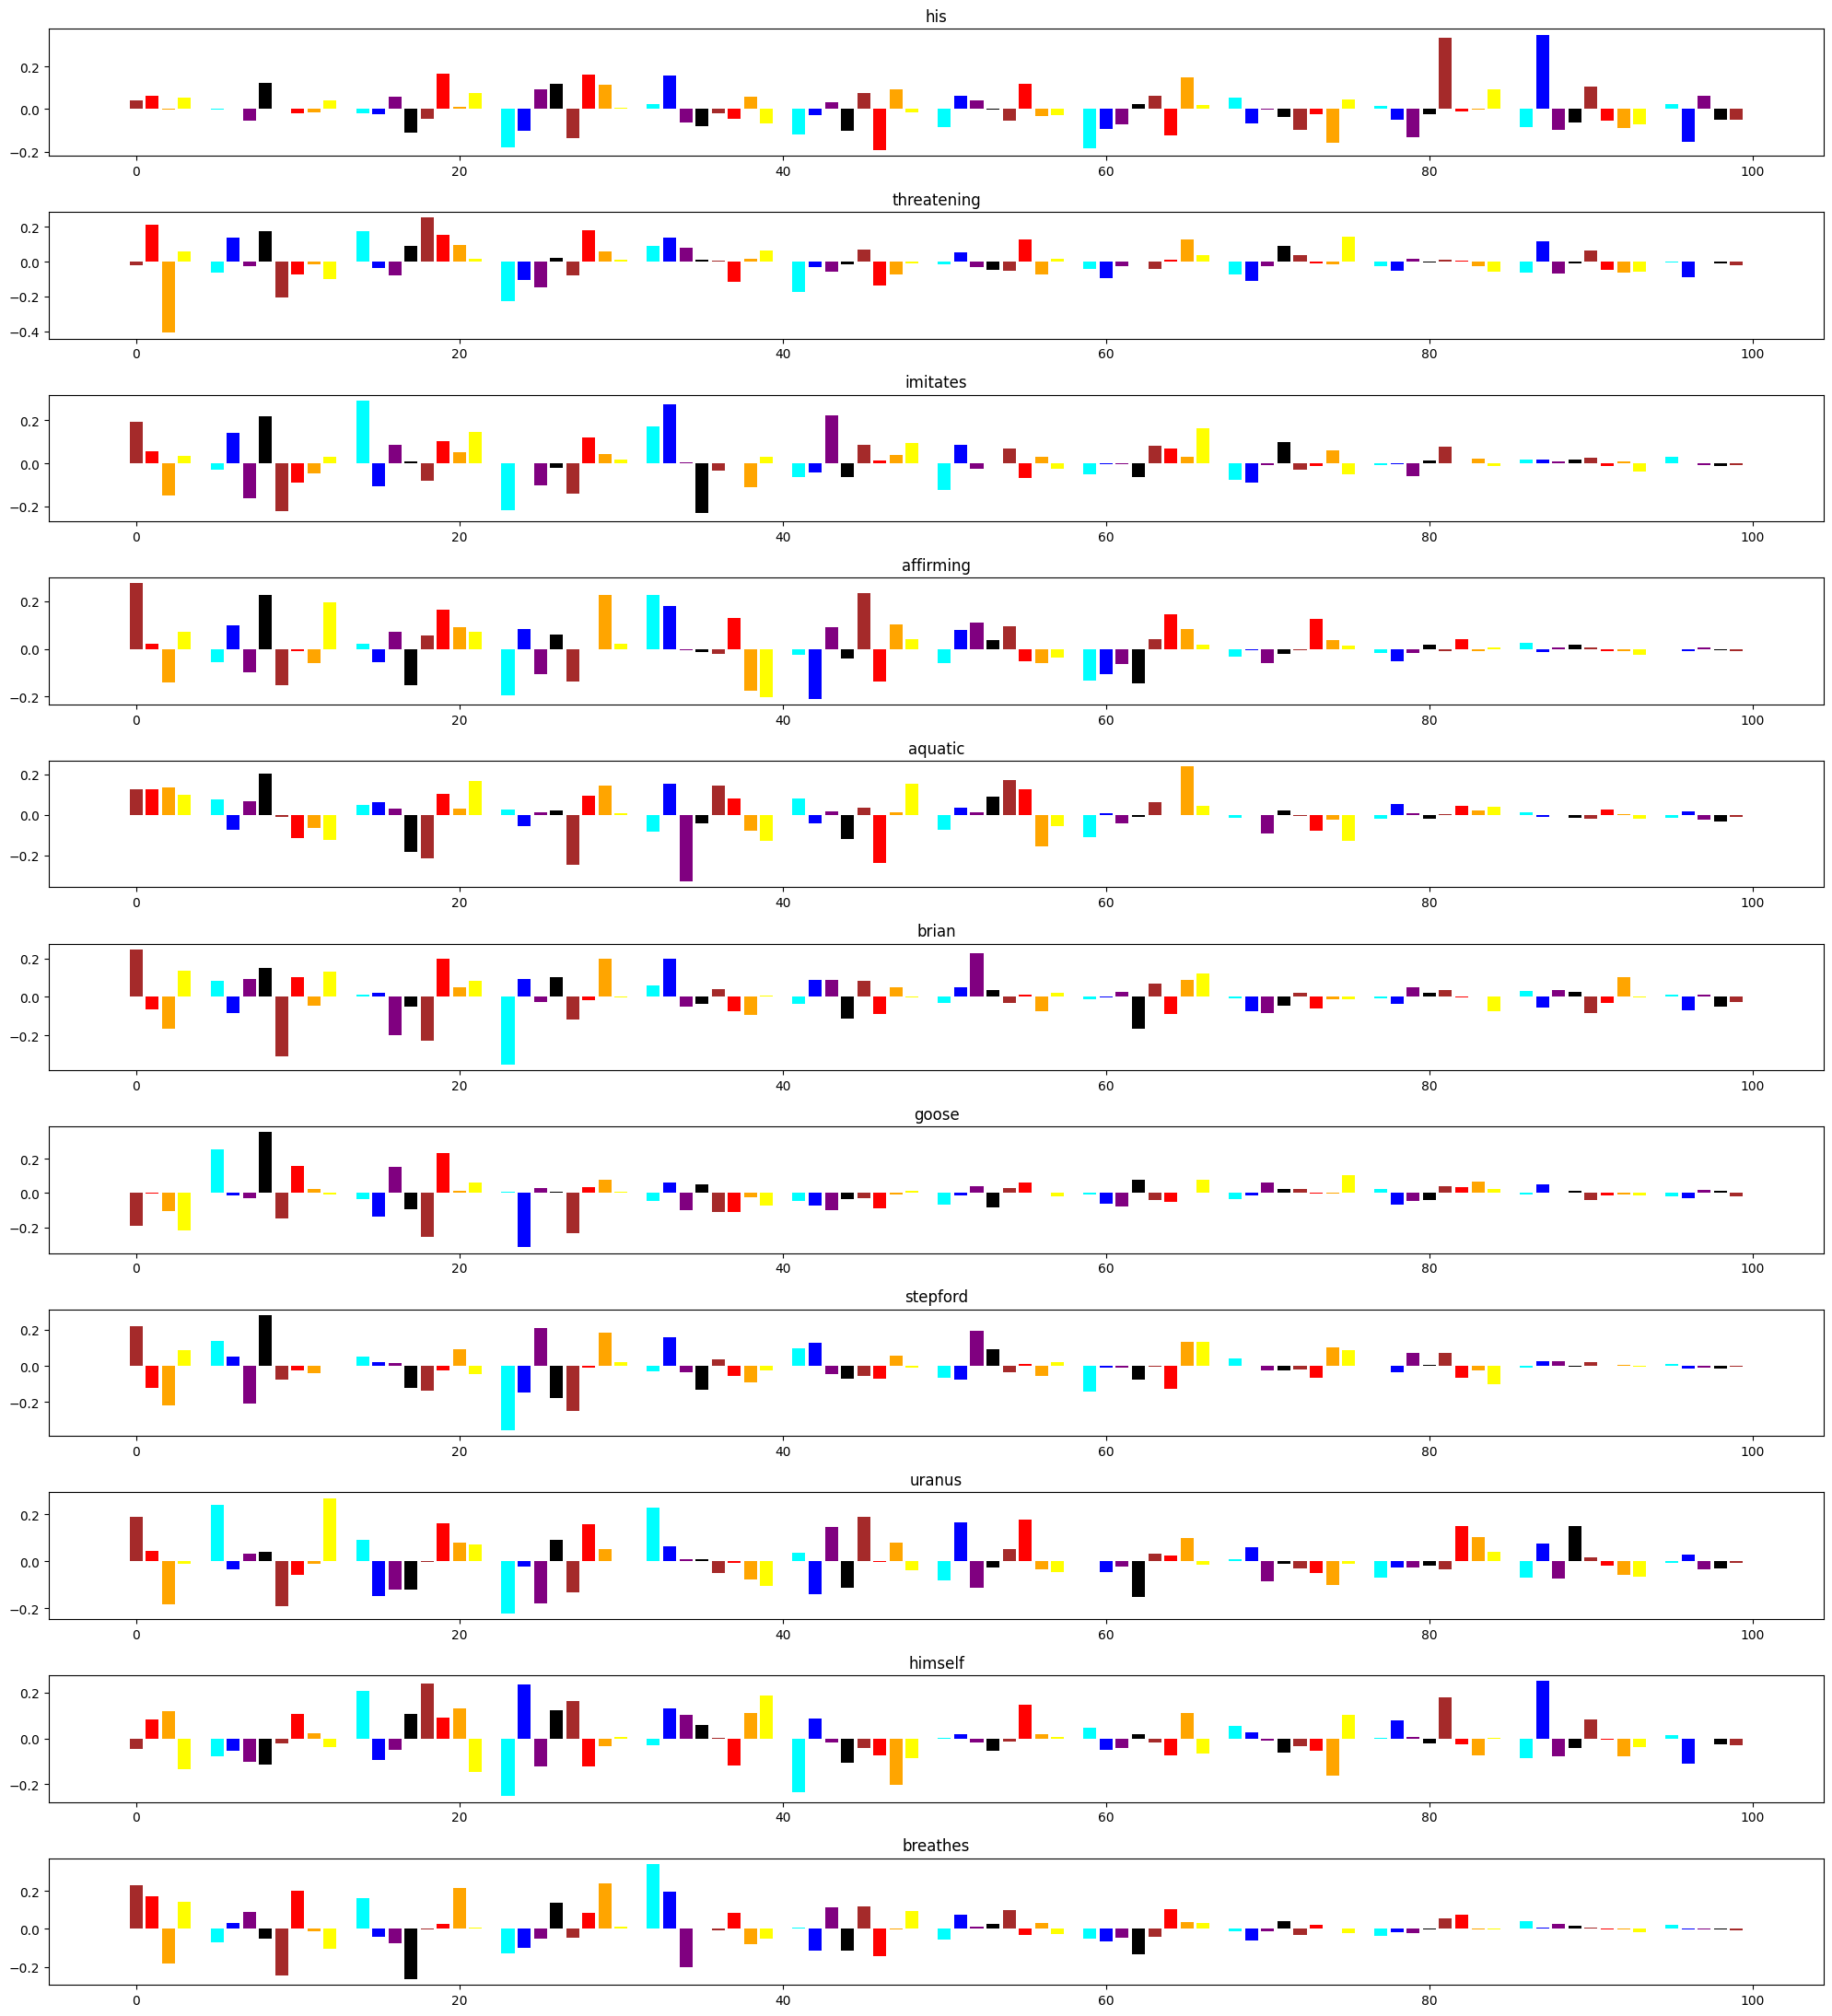

25089it [00:01, 18587.37it/s]


Word:  great
Top 10 similar words:  ['fantastic', 'wonderful', 'terrific', 'fabulous', 'wonderfull', 'macchio', 'splendid', 'classic', 'comeback', 'mcdowall']


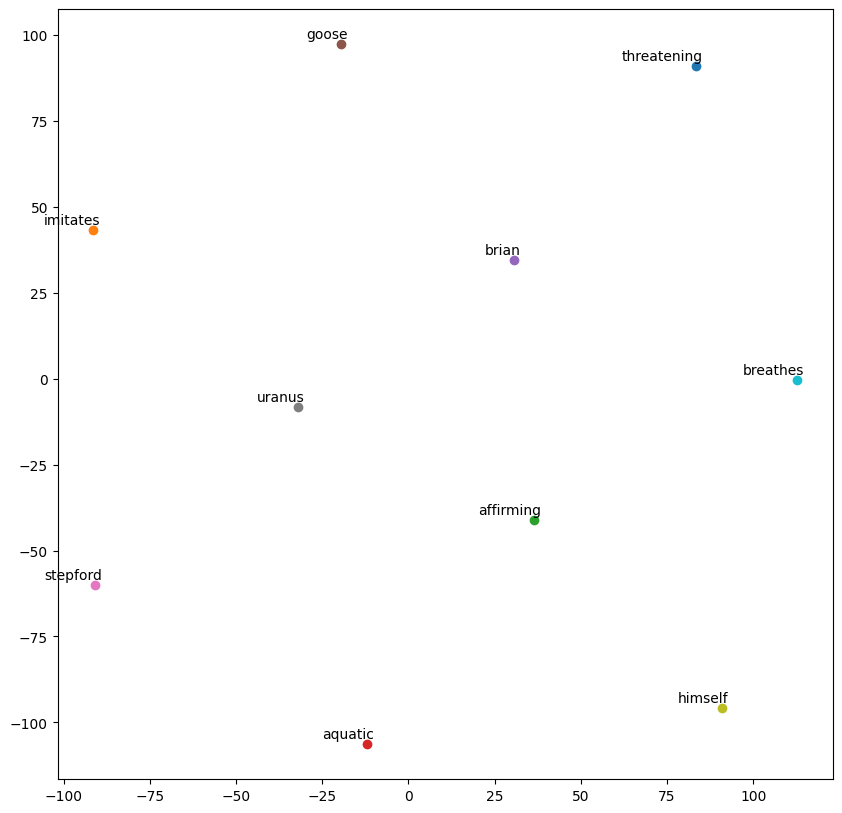

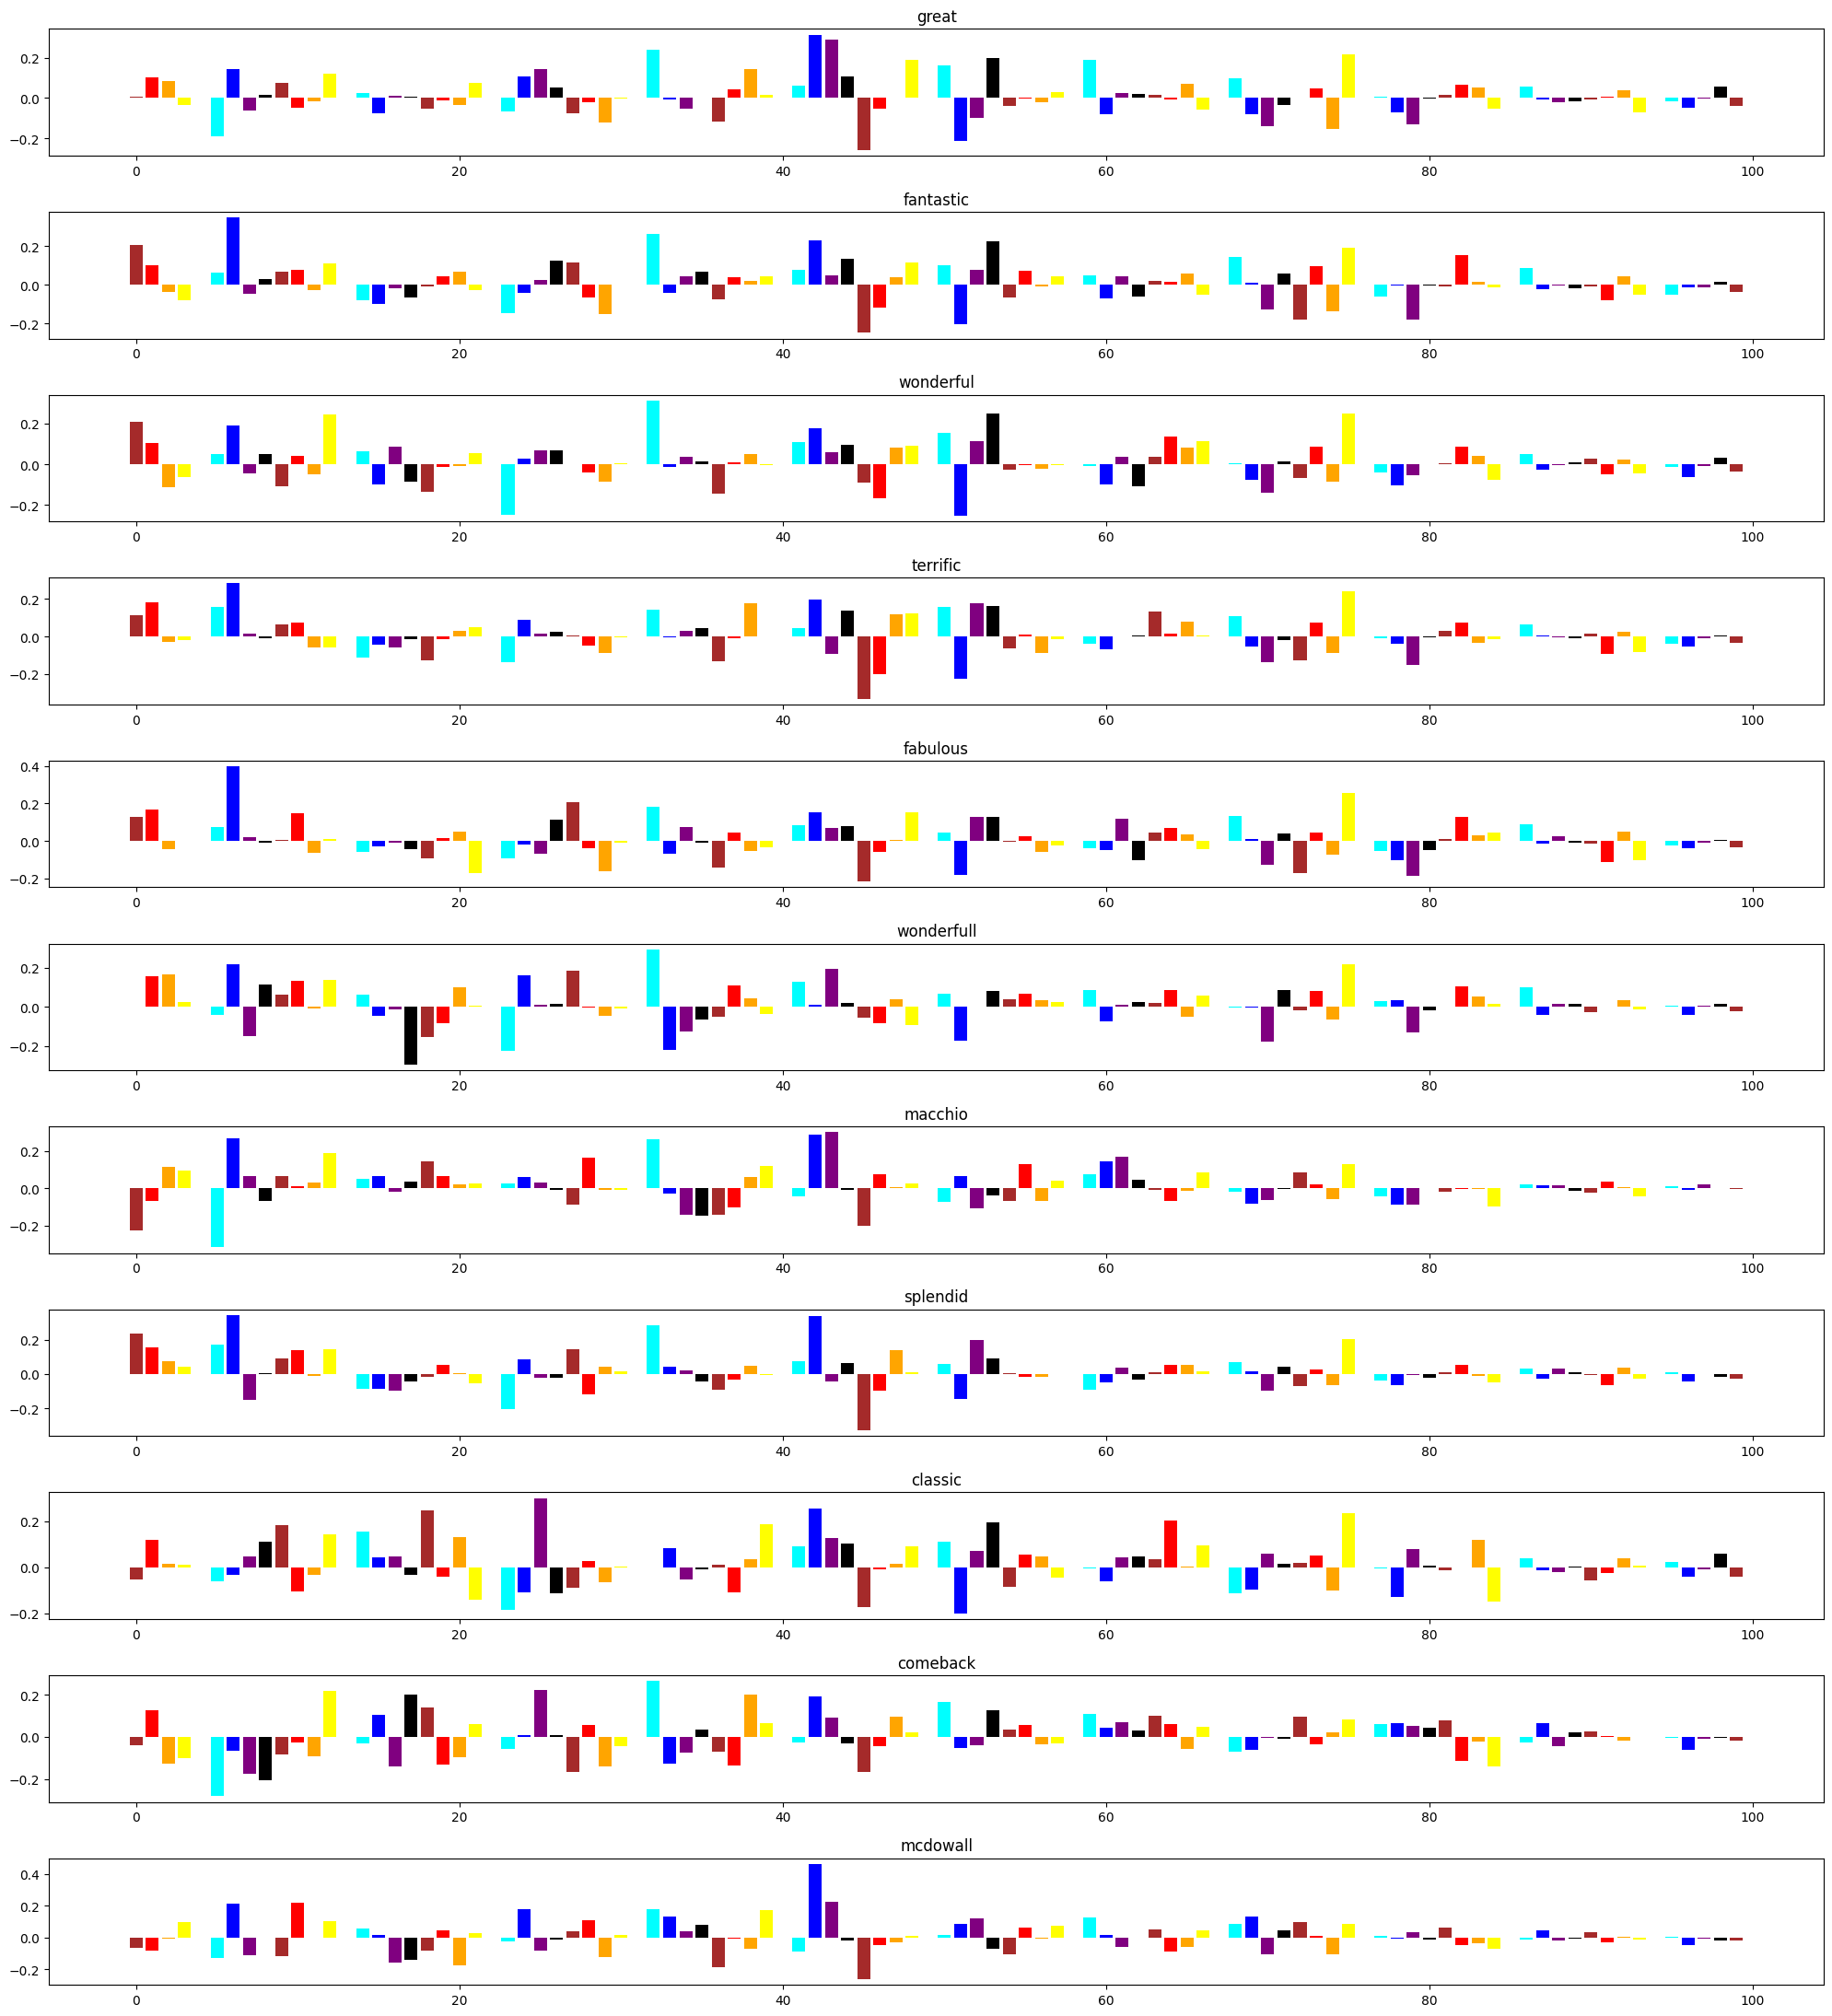

25089it [00:00, 25463.09it/s]


Word:  well
Top 10 similar words:  ['professionally', 'nicely', 'poorly', 'tastefully', 'harpo', 'beautifully', 'believeable', 'plotted', 'xmen', 'cheaply']


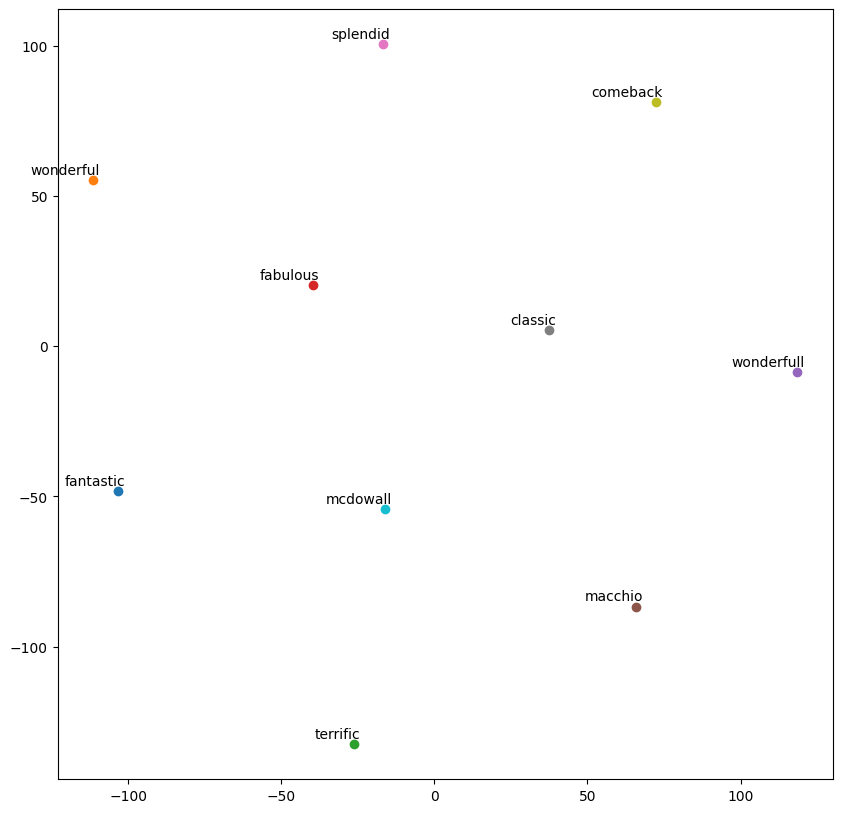

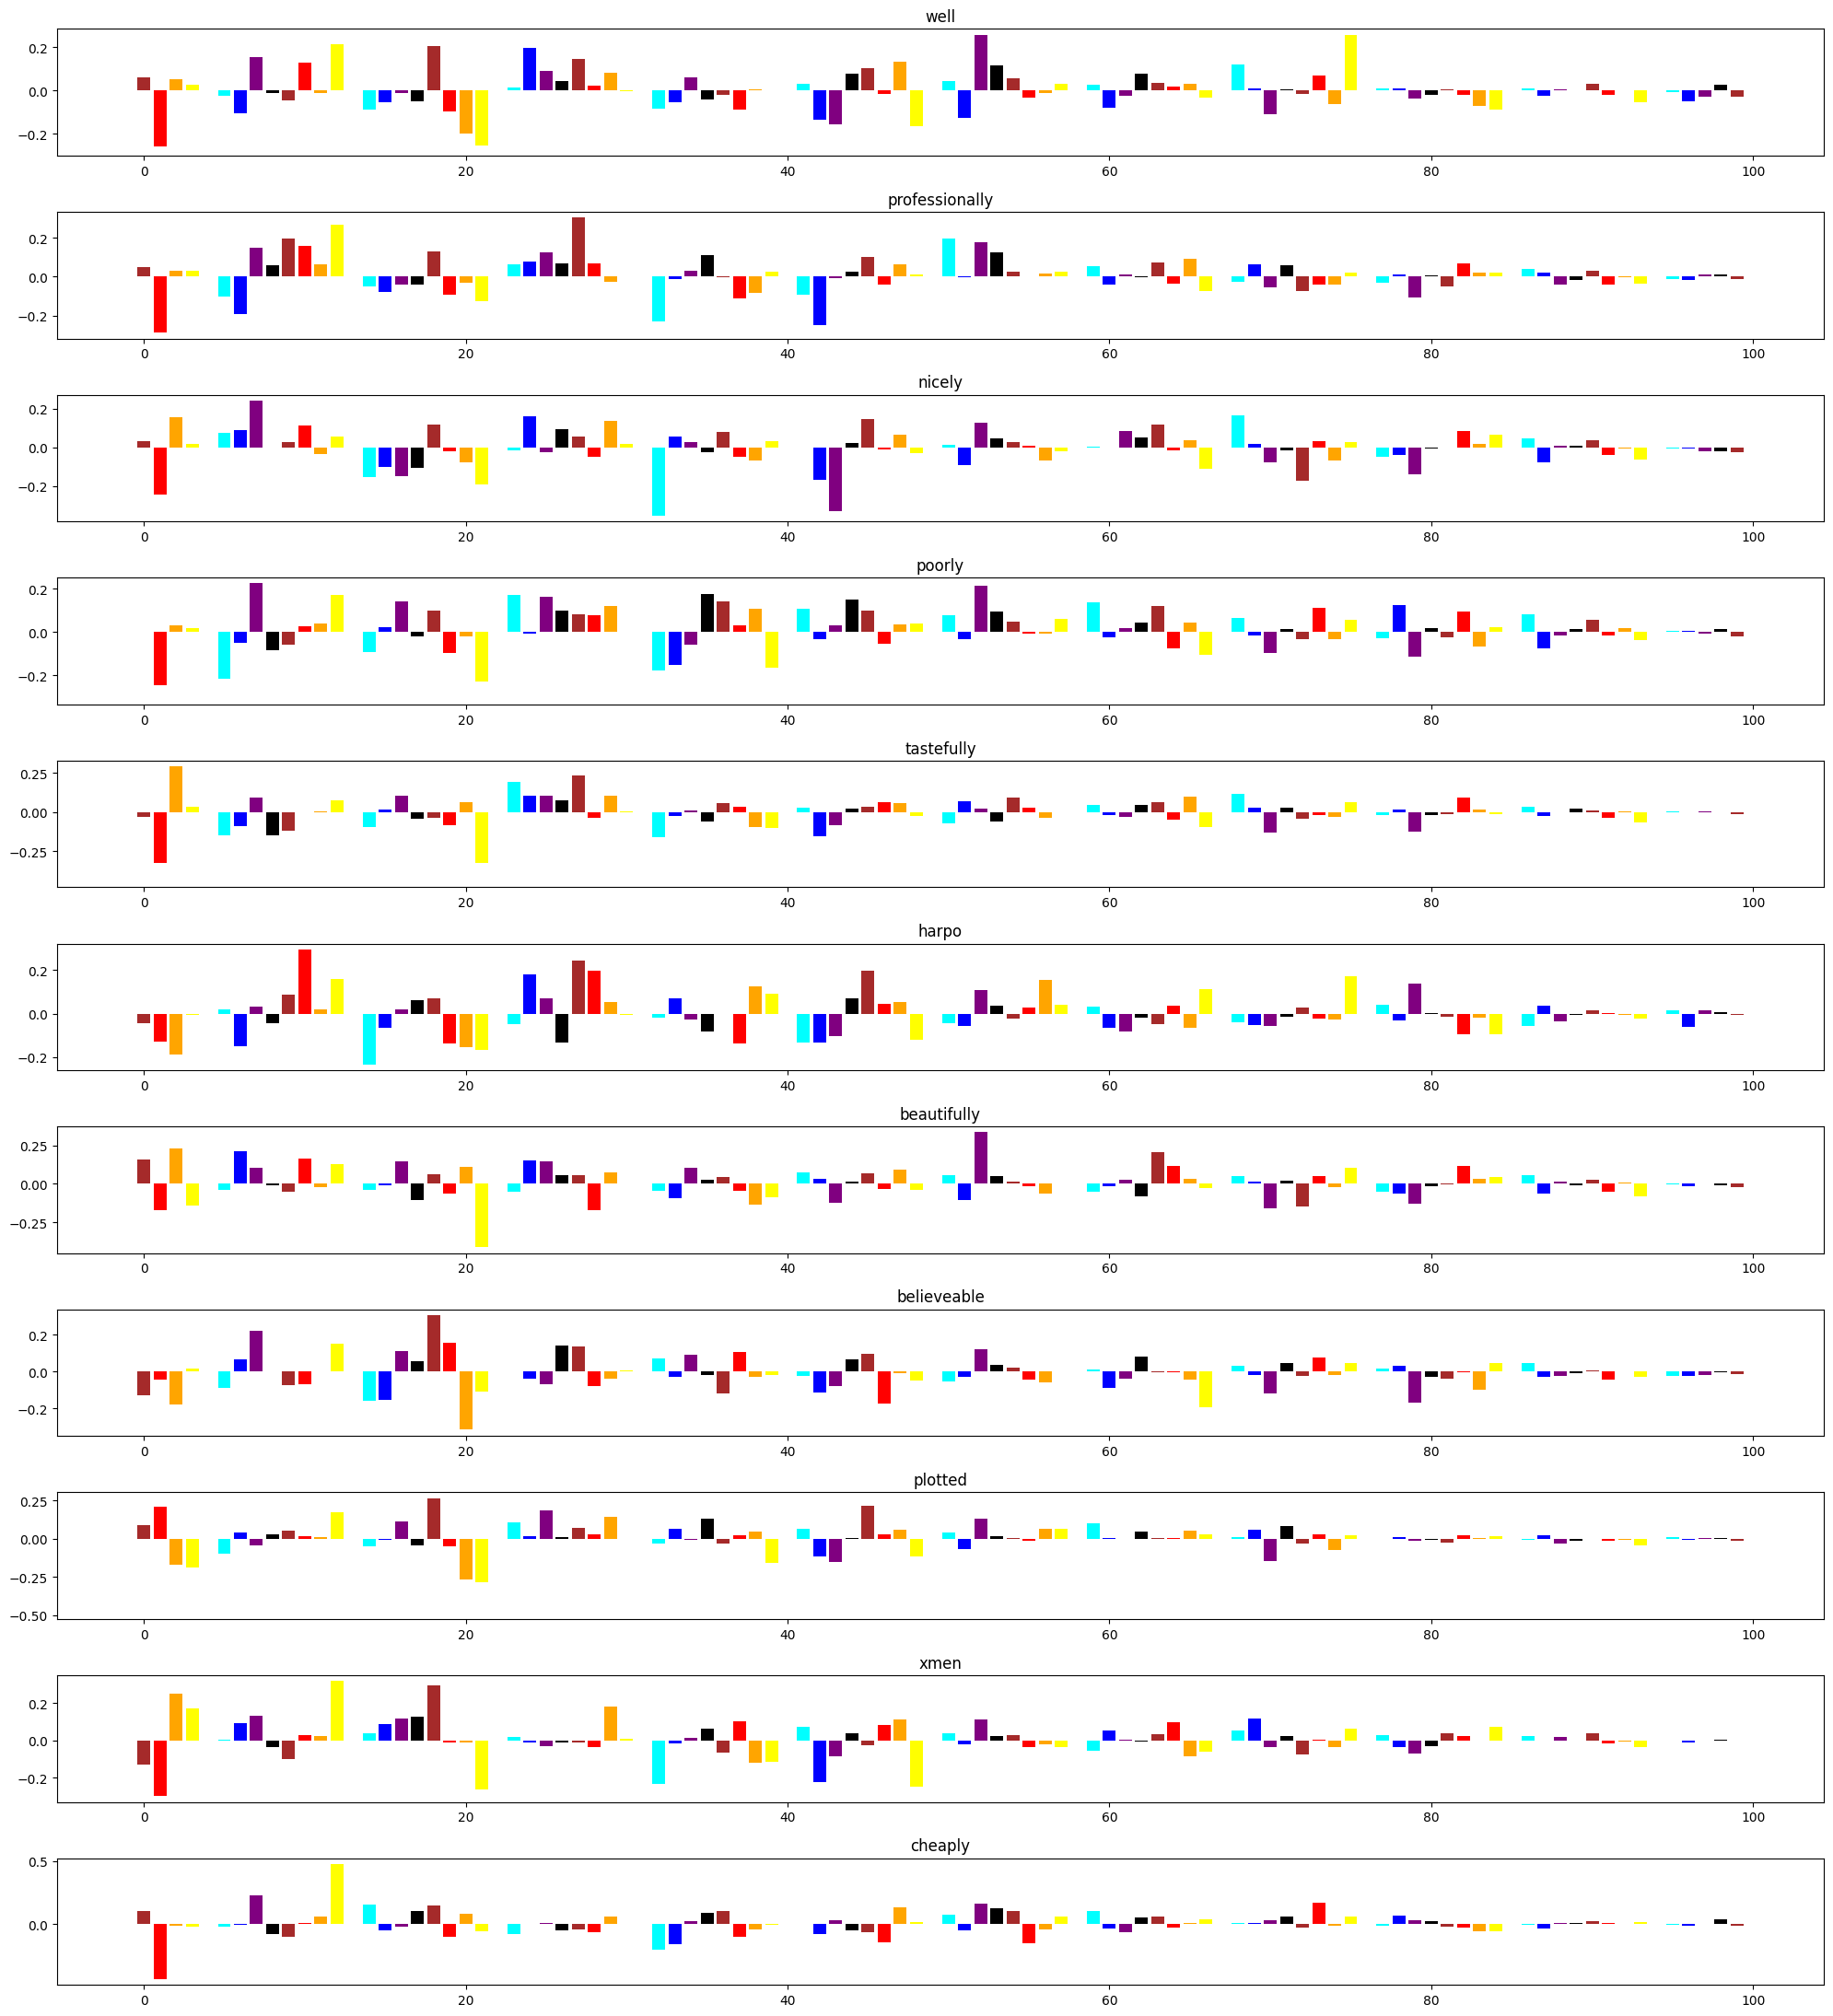

25089it [00:00, 26656.36it/s]


Word:  start
Top 10 similar words:  ['come', 'straight', 'coming', 'fued', 'finish', 'break', 'snatched', 'starting', 'downhill', 'rip']


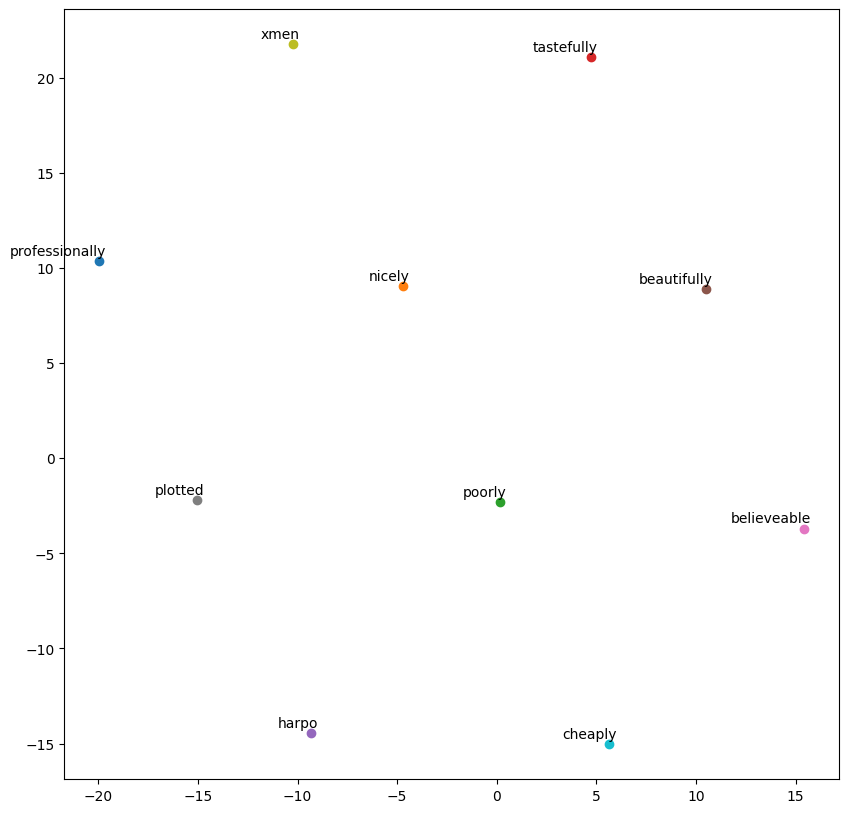

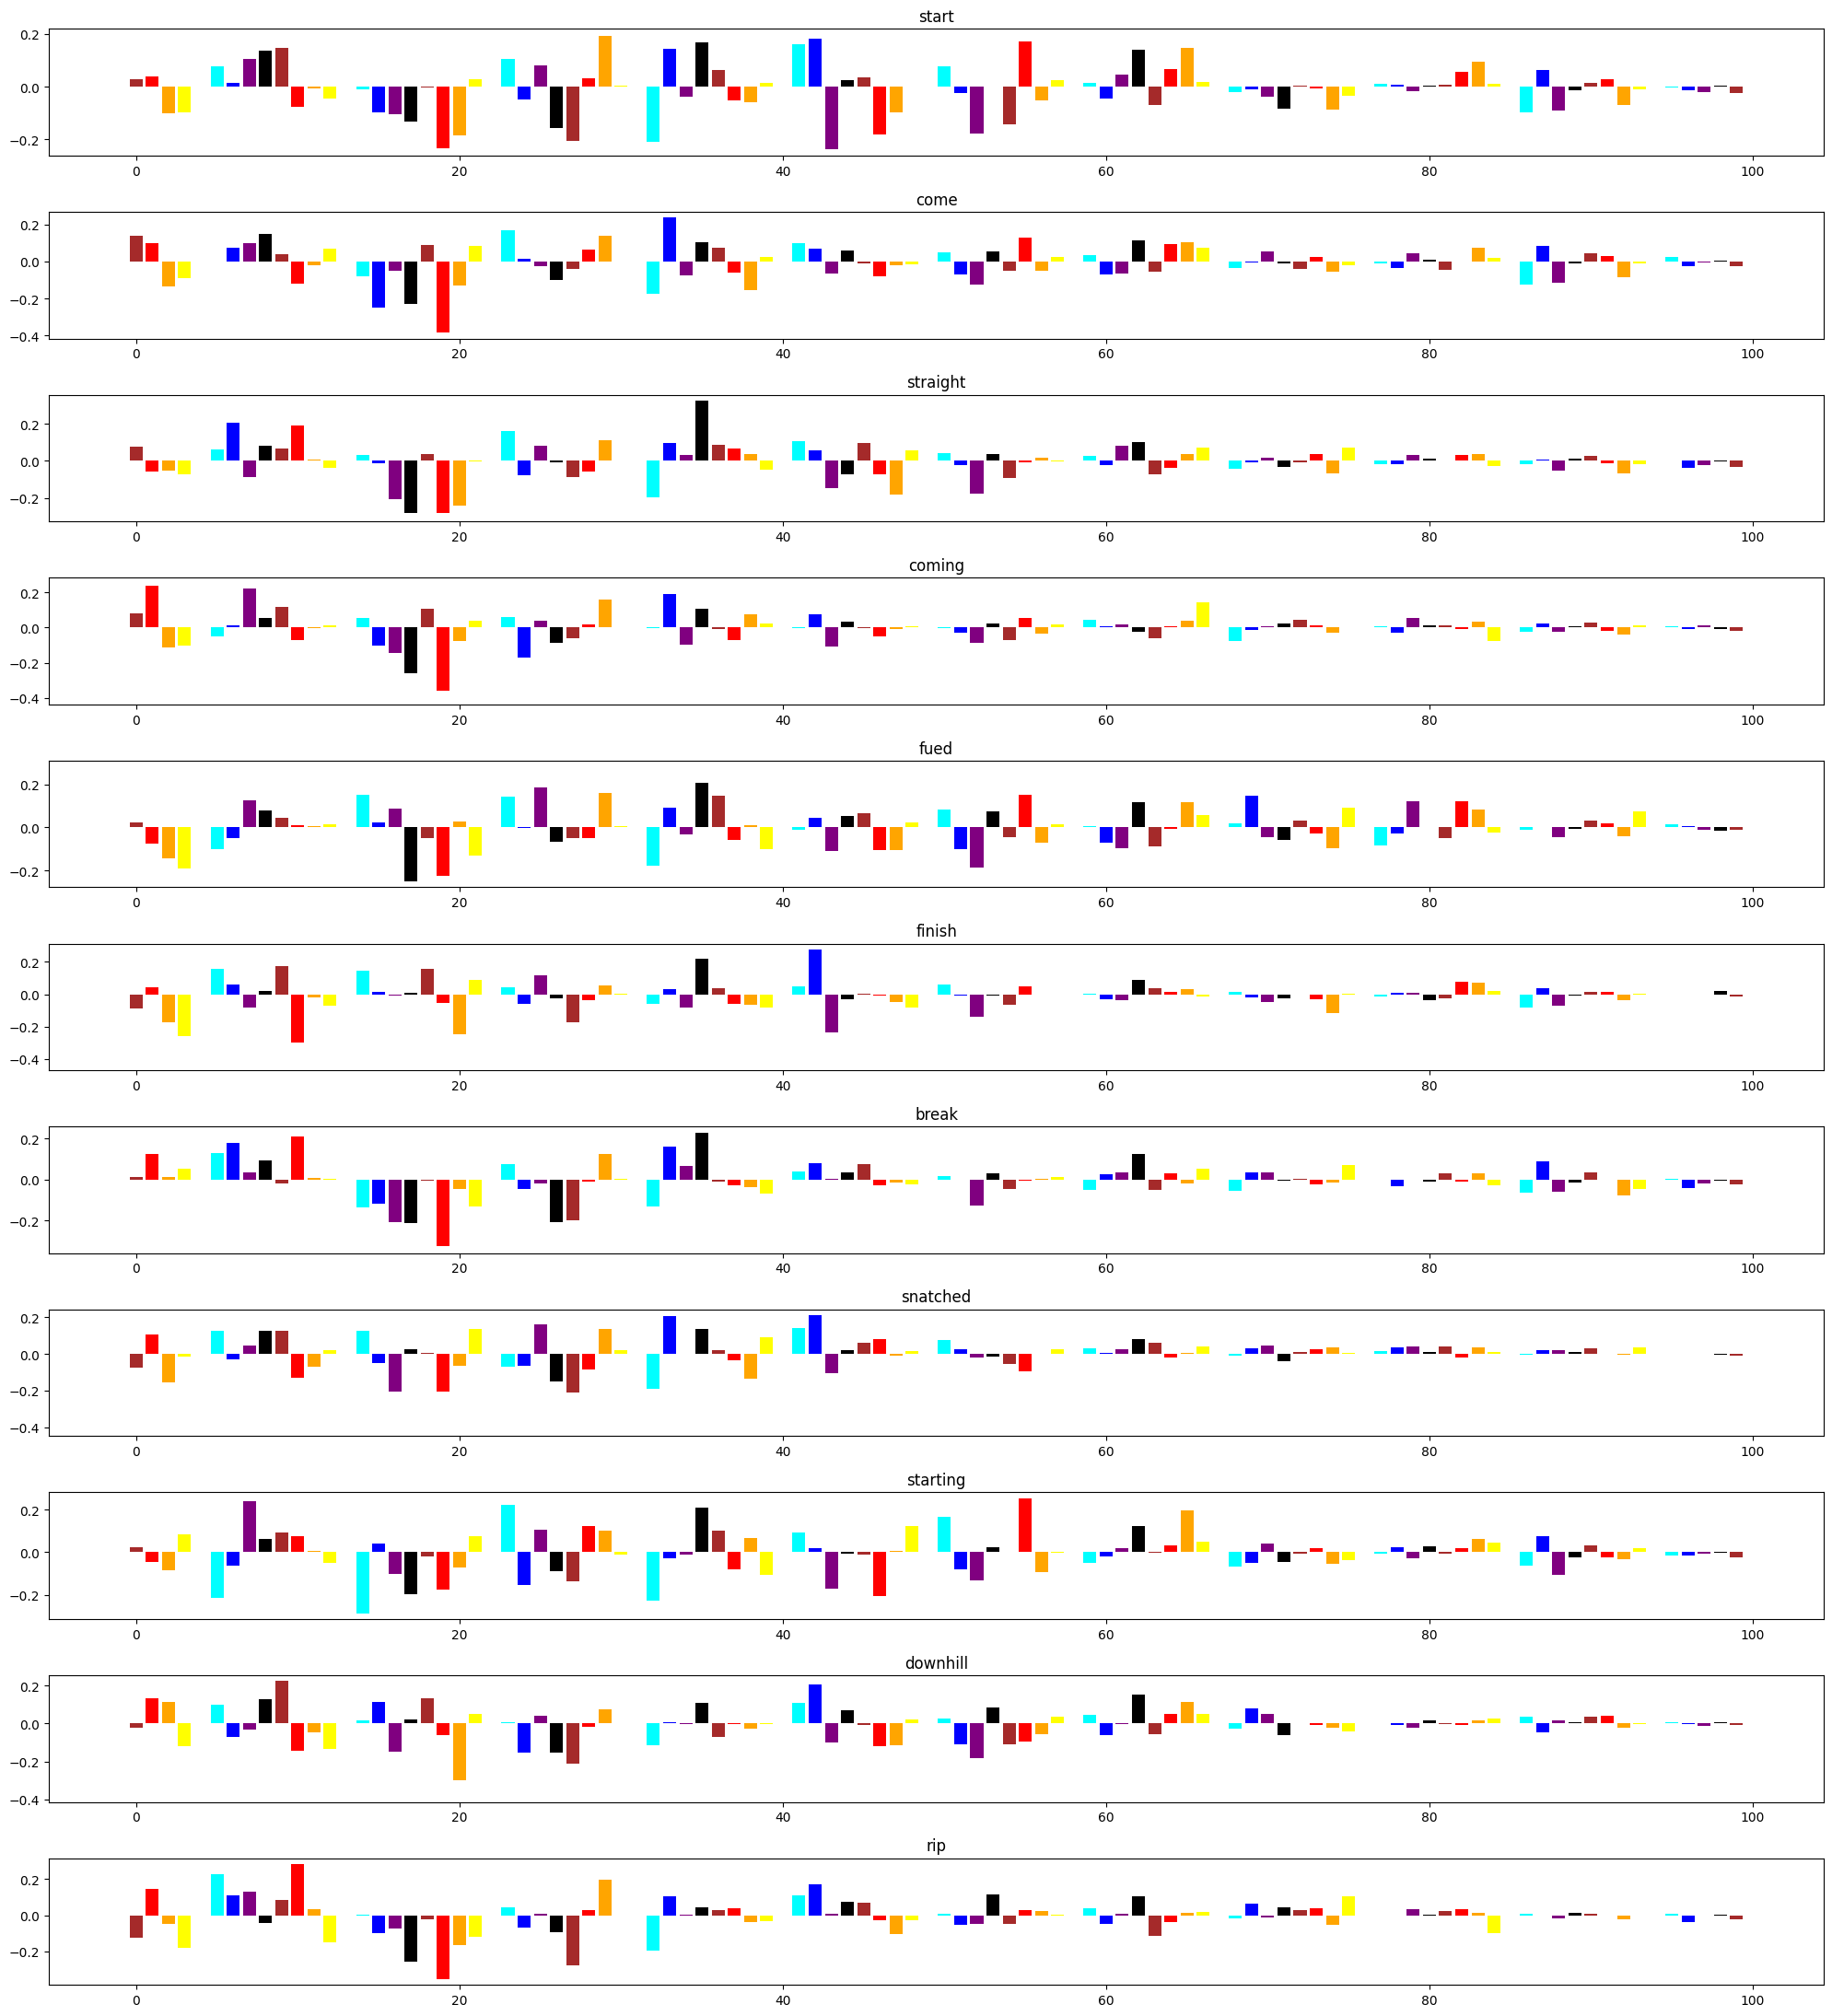

25089it [00:01, 21675.51it/s]


Word:  titanic
Top 10 similar words:  ['holocaust', '1928', 'surrounding', 'voyage', 'sinking', 'bombing', 'apollo', 'bulk', 'matrix', 'crux']


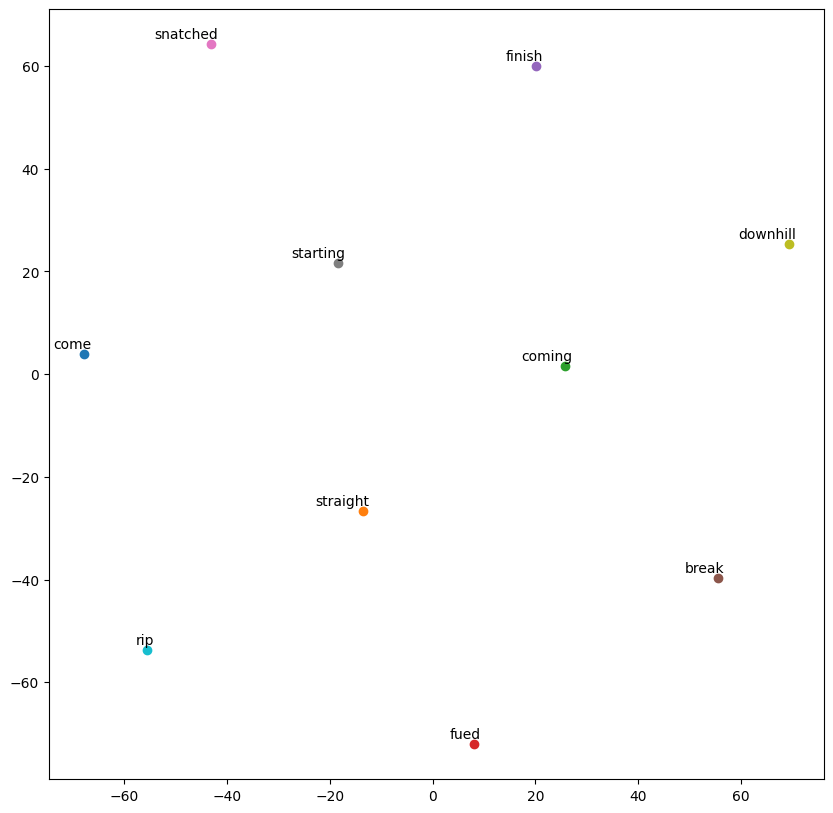

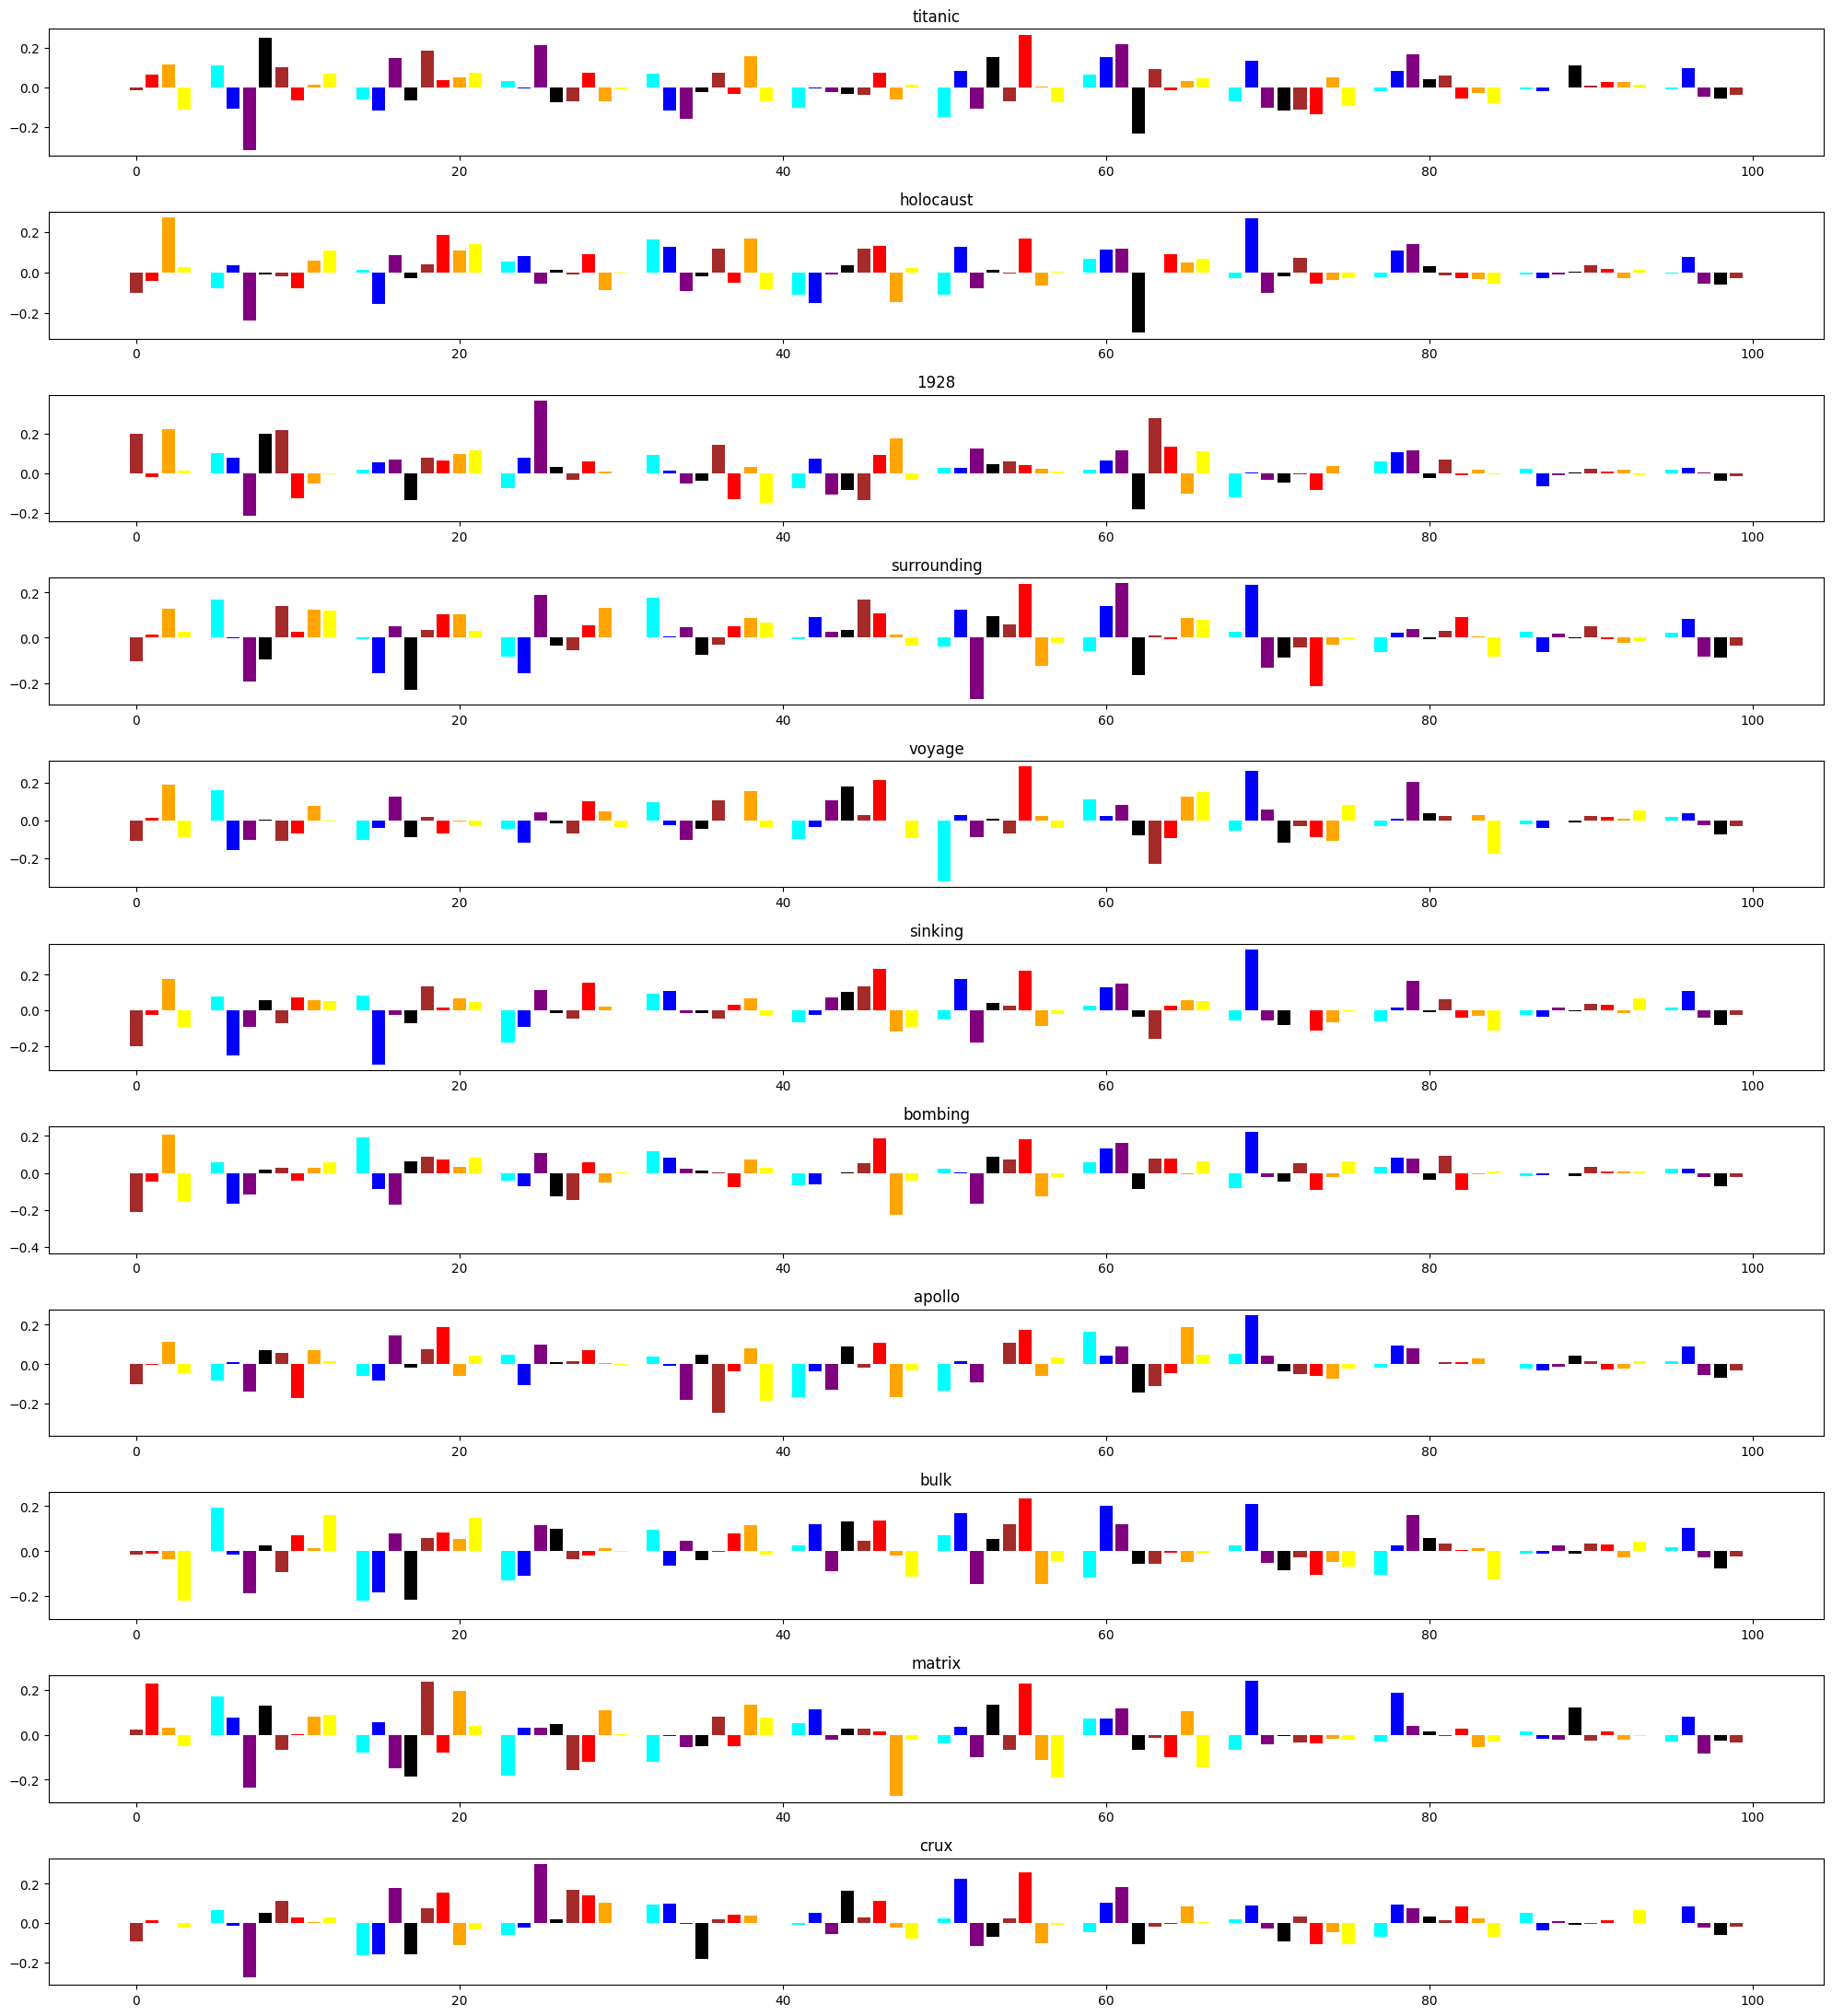

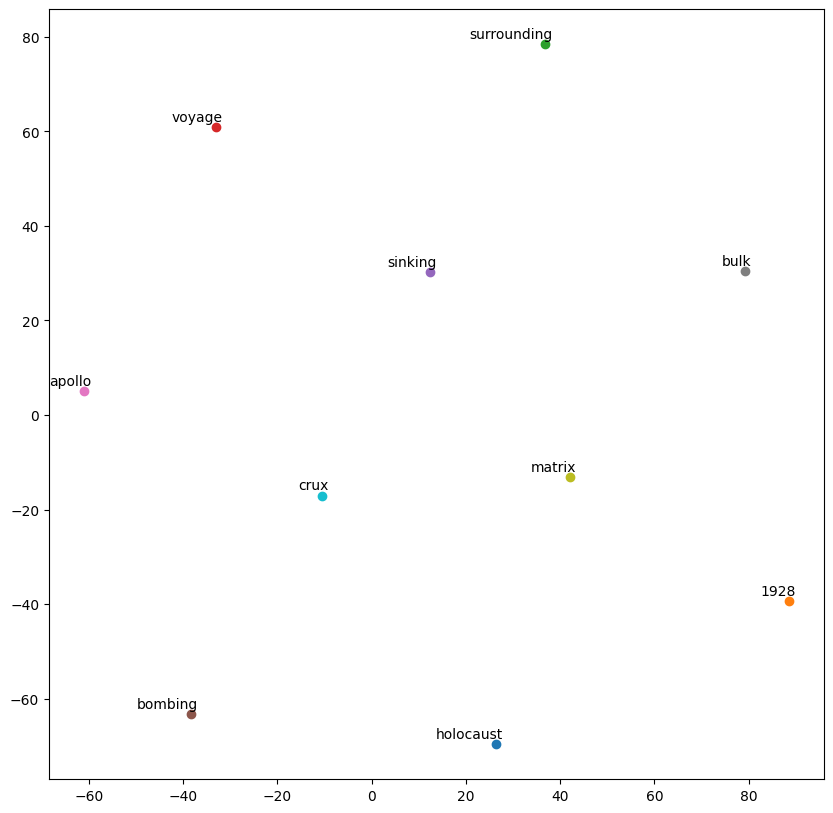

In [56]:
words = ['britain','his','great','well','start','titanic']
for word in words:
    plot_top_10_words(word,feature_list,svd_matrix)